# Capstone project -- Neighborhood Match

## Description of the problem

An average american moves 11.4 times in their lifetime, according to U.S. Census bureau. In case of cross country relocations, people sometimes have little knowledge about the new residence and its surroundings. Some might prefer neighborhoods with young families and entertainment, some -- more established neighborhoods, where the majority of residents have paid off their houses. To make things worse, there is lack of well structured information (not the data) and anecdotal evidences may affect people decision.

One way to mitigate the problem is to find neighborhood(s) similar to that of the persons' previous residence. To summarize, the objective of this project is to help people that are planning to move with finding the best fit neighborhood at the new residence. 

Beyond this class, the author also has a personal interest in the project as we are currently planning a cross-country move to Raleigh, North Carolina. For the 'ideal match', we used one of the authors' previous residences -- Murraywood, Columbia, South Carolina. Even though these cities and neighborhoods appear in the project, the code can easily adapt to pull data and work for practically *any* state in the United States.  

The general approach to solution is to cluster neighborhoods in Raleigh and identify what cluster Murraywood would be in. This cluster will contain similar neighborhoods that should be recommended. 

## Data 

In previous works for this class, the exclusive source of neighborhood data was Foursquare, which will also be used later. Here, however we also collect and analyze socioeconomic data on neighborhood residents. Web resource http://www.city-data.com provides this information at neighborhood level. The following attributes for each neighborhood will be collected:

* Neighborhood name
* Area (sq. miles)
* Population, males population, females population
* Average household size
* Average number of cars in apartments and houses
* Medium age of residents (males and females separately)
* Medium household income
* Medium rent, mortgage payments, percent mortgages;
* Percent of residents born in this state, in another U.S. state, foreign born residents
* Percent married, never married females and never married males over age of 15
* Percent of people not speaking English well
* Percent of single mother households

See a sample of socioeconomic data below.

### Foursquare data

Foursquare will provide data about venues within 500 meter radius for Murraywood and all Raleigh neighborhoods. Socioeconomic data and venue data will join and make the full dataset to analyze. 

### List of neighborhoods
http://www.city-data.com will provide a list of neighborhoods near Raleigh. For instance, http://www.city-data.com/indexes/neighborhoods/NC/1/ returns the first page (out of 51 pages total) of neighborhoods in North Carolina area. This list will further be filtered to contain only neighborhoods mentioning 'Raleigh'. 

## Examples of data used

### Socioeconomic (city-data.com)
Below is one example of city data for Anderson Heights neighborhood in Raleigh:

* 'Area:': '0.370',
* 'Population:': '964',
* 'avg household size': '2.8 people',
* 'avg number of cars apts': '1.9',
* 'avg number of cars houses': '2.3',
* 'males': '485',
* 'med age females': '39.2 years',
* 'med age males': '45.1 years',
* 'med household income': '\$161,702',
* 'med rent': '$1,125',
* 'pct born in another us state': '32.7%',
* 'pct born in state': '62.0%',
* 'pct families with children': '32.5%',
* 'pct family household': '66.2%',
* 'pct foreign born residents': '3.2%',
* 'pct married couple': '77.0%',
* 'pct native residents born outside us': '2.2%',
* 'pct never married females, 15 years old and older': '8.5%',
* 'pct never married males, 15 years old and older': '6.8%',
* 'pct not speak English well': '0.0%',
* 'pct single mother households': '1.8%',
* 'pct units mortgage': '72.3%'

This neighborhood is fairly large (964 people) with primarily U.S. born residents with above average household income. 

### Venues (foursquare.com)
The first five venues within 500 meters of Anderson Heights neighborhood are below:
*	Jersey Mike's Subs, Sandwich Place:	34.075935	-81.178343
*	Hungry Howie's Pizza, Pizza Place:	34.071897	-81.175538
*	Chapala, Mexican Restaurant:	34.075010	-81.178080
*	Loveland Coffee, Coffee Shop:	34.075771	-81.177871
*	Subway, Sandwich Place:	34.071150	-81.175505
*	Sun Ming, Chinese Restaurant:	34.087824	-81.184906

# Data Acquisition

This section covers data acquisition steps:

First -- experimental code:

* Convert neighborhood name to coordinates
* Pull venue data from coordinates:
    * Anderson heights, Raleigh, NC
    * Murraywood, Columbia, SC
* Scrape socioeconomic data

Second -- production code, i.e. the code used to build the dataset

* Scrape neighborhood names in Raleigh, NC;
* Scrape socioeconomic data;
* Pull venue data;
* Join socioeconomic data and venues data;


## Convert neighborhoods to coordinates

In [2]:
import numpy as np
import pandas as pd

from geopy.geocoders import Nominatim

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [41]:
# Check to see how well Nominatim can convert neighborhood name to coordinates
inputAddress = 'Anderson Heights, Raleigh, NC' 

def get_neigh_coords(inputAddress):
    geolocator = Nominatim(user_agent = 'my-application')
    location = geolocator.geocode(inputAddress)
    return location.latitude,location.longitude

get_neigh_coords(inputAddress)

(35.8178634, -78.6377824196471)

## Foursquare data pulls -- single neighborhoods

In [81]:
# Pull API keys from the file
with open('foursquare_keys.txt','r') as f:
    CLIENT_ID, CLIENT_SECRET = [l.strip() for l in f.readlines()]

VERSION = '20180605' # Foursquare API version

In [11]:
# Define an auxiliary function to pull the category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Test run -- pull venues around Anderson heights

In [82]:
# Pull up to 100 venues within 500 meters

radius = 1*500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Jersey Mike's Subs,Sandwich Place,34.075935,-81.178343
1,Chapala,Mexican Restaurant,34.075010,-81.178080
2,Loveland Coffee,Coffee Shop,34.075771,-81.177871
3,The UPS Store,Shipping Store,34.075761,-81.178363
4,Foot Solutions,Shoe Store,34.076065,-81.178284
5,Talbots,Clothing Store,34.076485,-81.178542
6,New Life Fitness World,Gym,34.075847,-81.176657
7,Long's Drugs Of Irmo,Pharmacy,34.079629,-81.180247


In [29]:
# putting it all together -- function to read a list of venues for a neighborhood

def get_venues(inputAddress, radius = 500, limit = 100):
    lat, lon = get_neigh_coords(inputAddress)
    return lat,lon

get_venues('Murraywood, Irmo, SC')

(34.0767364, -81.1789118)

### Test run -- pull venues around Murraywood

In [30]:
# Pull up to 100 venues within 500 meters of the borough

latitude, longitude = get_venues('Murraywood, Irmo, SC')
radius = 1*500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Jersey Mike's Subs,Sandwich Place,34.075935,-81.178343
1,Chapala,Mexican Restaurant,34.075010,-81.178080
2,Loveland Coffee,Coffee Shop,34.075771,-81.177871
3,The UPS Store,Shipping Store,34.075761,-81.178363
4,Foot Solutions,Shoe Store,34.076065,-81.178284
5,Talbots,Clothing Store,34.076485,-81.178542
6,New Life Fitness World,Gym,34.075847,-81.176657
7,Long's Drugs Of Irmo,Pharmacy,34.079629,-81.180247


## Scrape socioeconomic data

### Build web scraping code

Experiments with pulling data from city-data.com

In [91]:
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize

In [92]:
# test it for Murraywood neighborhood first
url = "http://www.city-data.com/neighborhood/Murraywood-Columbia-SC.html"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [ ]:
row_data = soup.find(class_='row')
row_data

In [94]:
item = row_data.find(class_='content-item')
item

<div class="content-item"><br/><b>Area:</b> 7.865 <b>square miles</b><br/><br/>
<b>Population:</b> 6,110<br/><br/>
<b>Population density:</b><br/><div class="hgraph"><table><tr><td><b>Murraywood (Murray Woods):</b></td><td><p class="h" style="padding-left:108px;"></p>777 <b>people per square mile</b></td></tr><tr><td><b>Columbia:</b></td><td><p class="a" style="padding-left:150px;"></p>1,070 <b>people per square mile</b></td></tr></table></div>
</div>

In [95]:
# extract area and population
d = {}
for i in item.find_all('b'):
    try:
        key = i.text.strip()
        value = i.next_sibling.strip()
        d[key] = value
    except:
        pass
d

{'Area:': '7.865', 'Population:': '6,110'}

In [97]:
# function to pull data from hgraph 
def pull_value(hg, item_pos):
    return hg[item_pos].find('table').find_all('tr')[0].find_all('td')[1].text

# test function above on another hgraph
hg = row_data.find_all(class_ = 'hgraph')[1:]
pull_value(hg,2)

'2,822'

In [98]:
# pull all data from the page
keys = ['med household income'
        ,'med rent'
        ,'males'
        ,'med age males'
        ,'med age females'
        ,'avg household size'
        ,'pct family household'
        ,'pct married couple'
        ,'pct families with children'
        ,'pct single mother'
        ,'pct never married males > 15'
        ,'pct never married females > 15'
        ,'pct not speak English well'
        ,'pct born in state'
        ,'pct born in another us state'
       ,'pct native residents born outside us'
       ,'pct foreign born residents'
       ,'avg number of cars houses'
       ,'avg number of cars apts'
       ,'pct units mortgage']
values = [pull_value(hg, pos) for pos in range(0,20)]
dict(zip(keys,values))

{'avg household size': '7.8 people',
 'avg number of cars apts': '1.8',
 'avg number of cars houses': '1.9',
 'males': '2,822',
 'med age females': '37.8 years',
 'med age males': '40.4 years',
 'med household income': '$81,120',
 'med rent': '$679',
 'pct born in another us state': '37.4%',
 'pct born in state': '56.6%',
 'pct families with children': '30.7%',
 'pct family household': '52.0%',
 'pct foreign born residents': '3.4%',
 'pct married couple': '46.5%',
 'pct native residents born outside us': '2.6%',
 'pct never married females > 15': '14.8%',
 'pct never married males > 15': '15.4%',
 'pct not speak English well': '2.0%',
 'pct single mother': '12.1%',
 'pct units mortgage': '74.3%'}

In [99]:
# join both datasets: (area,population)+(rest of the data)
z = d.copy()
z.update(dict(zip(keys,values)))
z
# area in sq. miles

{'Area:': '7.865',
 'Population:': '6,110',
 'avg household size': '7.8 people',
 'avg number of cars apts': '1.8',
 'avg number of cars houses': '1.9',
 'males': '2,822',
 'med age females': '37.8 years',
 'med age males': '40.4 years',
 'med household income': '$81,120',
 'med rent': '$679',
 'pct born in another us state': '37.4%',
 'pct born in state': '56.6%',
 'pct families with children': '30.7%',
 'pct family household': '52.0%',
 'pct foreign born residents': '3.4%',
 'pct married couple': '46.5%',
 'pct native residents born outside us': '2.6%',
 'pct never married females > 15': '14.8%',
 'pct never married males > 15': '15.4%',
 'pct not speak English well': '2.0%',
 'pct single mother': '12.1%',
 'pct units mortgage': '74.3%'}

### Function to pull socioeconomic data from neighborhood URL

In [100]:
# Function to extract all data for a neighborhood from page URL

keys = ['med household income'
        ,'med rent'
        ,'males'
        ,'med age males'
        ,'med age females'
        ,'avg household size'
        ,'pct family household'
        ,'pct married couple'
        ,'pct families with children'
        ,'pct single mother'
        ,'pct never married males > 15'
        ,'pct never married females > 15'
        ,'pct not speak English well'
        ,'pct born in state'
        ,'pct born in another us state'
       ,'pct native residents born outside us'
       ,'pct foreign born residents'
       ,'avg number of cars houses'
       ,'avg number of cars apts'
       ,'pct units mortgage']

def pull_neigh_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    row_data = soup.find(class_='row')
    item = row_data.find(class_='content-item')
    d = {}
    for i in item.find_all('b'):
        try:
            key = i.text.strip()
            value = i.next_sibling.strip()
            d[key] = value
        except:
            pass
    hg = row_data.find_all(class_ = 'hgraph')[1:]
    values = [pull_value(hg, pos) for pos in range(0,20)]
    z = d.copy()
    z.update(dict(zip(keys,values)))
    return z

# test run on Murraywood
pull_neigh_data("http://www.city-data.com/neighborhood/Murraywood-Columbia-SC.html")

{'Area:': '7.865',
 'Population:': '6,110',
 'avg household size': '7.8 people',
 'avg number of cars apts': '1.8',
 'avg number of cars houses': '1.9',
 'males': '2,822',
 'med age females': '37.8 years',
 'med age males': '40.4 years',
 'med household income': '$81,120',
 'med rent': '$679',
 'pct born in another us state': '37.4%',
 'pct born in state': '56.6%',
 'pct families with children': '30.7%',
 'pct family household': '52.0%',
 'pct foreign born residents': '3.4%',
 'pct married couple': '46.5%',
 'pct native residents born outside us': '2.6%',
 'pct never married females > 15': '14.8%',
 'pct never married males > 15': '15.4%',
 'pct not speak English well': '2.0%',
 'pct single mother': '12.1%',
 'pct units mortgage': '74.3%'}

In [289]:
# Another test run on Anderson Heights
pull_neigh_data('http://www.city-data.com/neighborhood/Anderson-Heights-Raleigh-NC.html')

{'Area:': '0.370',
 'Population:': '964',
 'avg household size': '2.8 people',
 'avg number of cars apts': '1.9',
 'avg number of cars houses': '2.3',
 'males': '485',
 'med age females': '39.2 years',
 'med age males': '45.1 years',
 'med household income': '$161,702',
 'med rent': '$1,125',
 'pct born in another us state': '32.7%',
 'pct born in state': '62.0%',
 'pct families with children': '32.5%',
 'pct family household': '66.2%',
 'pct foreign born residents': '3.2%',
 'pct married couple': '77.0%',
 'pct native residents born outside us': '2.2%',
 'pct never married females > 15': '8.5%',
 'pct never married males > 15': '6.8%',
 'pct not speak English well': '0.0%',
 'pct single mother': '1.8%',
 'pct units mortgage': '72.3%'}

## Scrape List of Neighborhoods in North Carolina (production)

Still need to pull the list of neighborhood names from www.city-data.com

In [228]:
# The list of neighborhoods is available at the following url
page_no = 1 # use only the first page for now
url = "http://www.city-data.com/indexes/neighborhoods/NC/%d/"%page_no

page = requests.get(url)
soup = BeautifulSoup(page.text, 'html.parser')

In [244]:
li = soup.find_all('li')
li[100] # show one of the neighborhoods

<li><a href="/neighborhood/Anderson-Heights-Raleigh-NC.html">Anderson Heights neighborhood in Raleigh, NC</a></li>

In [251]:
url_prefix = 'http://www.city-data.com'

# function returns neighborhood name and url for a list item
def get_neigh_url(li_item):
    value = url_prefix+li_item.find('a').get('href')
    key = li_item.text
    return (key,value)
    
print(get_neigh_url(li[100]))


('Anderson Heights neighborhood in Raleigh, NC', 'http://www.city-data.com/neighborhood/Anderson-Heights-Raleigh-NC.html')


In [ ]:
# Scrape all neighborhood names from one page identified by page_no
def scrape_page(page_no):
    url = "http://www.city-data.com/indexes/neighborhoods/NC/%d/"%page_no
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    urls_dict = []
    for li_item in soup.find_all('li'):
        if li_item.text.find('Raleigh, NC') >= 0: # Use only neighborhoods containing 'Raleigh, NC' in their name
            urls_dict.append(get_neigh_url(li_item))
    return urls_dict

# Example -- scrape page 2 from the website
scrape_page(2)

In [ ]:
# Go through all pages and scrape neighborhood names
from random import randint
from time import sleep

urls_dict = []

for page_no in range(1,51): # there are 50 pages total
    d = scrape_page(page_no)
    urls_dict = urls_dict + d
    print("Processed page %d of 51"%page_no)
    sleep(randint(3,20)) # introduce a random sleep to simulate human interaction
    print("waiting...")
    
print(urls_dict)

In [261]:
# total number of neighborhoods scraped
len(urls_dict)

1499

In [264]:
# save neighborhood names and urls for later usage
import pickle
with open('urls_dict.pickle','wb') as f:
    pickle.dump(urls_dict, f)

## Scrape Socioeconomic Data (production)

Now that we have the full list of urls and neighborhood names, we can scrape socioeconomic data for each neighborhood in the list

In [ ]:
# Run the scraping code for each url in the list (total of ~1500)
# CAREFUL -- this code will take long time to complete
l = []
count = 0
for name, url in urls_dict:
    print(url)
    try:
        d = pull_neigh_data(url)
        d['neighborhood'] = name
        l.append(d)
        count += 1
        print("%s processed (%d), now waiting..."%(name,count))
    except: # something went wrong, i.e. the page does not contain the needed data
        print("%s unable to pull data"%(name))
    sleep(randint(3,20)) # random sleep to simulate human interaction
    
l

In [ ]:
# convert scraped data to a Pandas dataframe
import pandas as pd
df = pd.DataFrame(l)
df

In [85]:
# Save for later use
df.to_csv('raleigh_neighs.csv')

In [112]:
# add murraywood neighborhood to df
row = pull_neigh_data("http://www.city-data.com/neighborhood/Murraywood-Columbia-SC.html")

# If Murraywood has not been added, add it to the dataset
if len(df[df['neighborhood'] == 'Murraywood, Columbia, SC']) == 0:
    df = df.append(pd.Series(row), ignore_index = True)
    
df[df['neighborhood'] == 'Murraywood, Columbia, SC']

,Unnamed: 0,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,...,pct families with children,pct family household,pct foreign born residents,pct married couple,pct native residents born outside us,pct never married females > 15,pct never married males > 15,pct not speak English well,pct single mother,pct units mortgage
668,NaN,7.865,"6,110",7.8 people,1.8,1.9,"2,822",37.8 years,40.4 years,"$81,120",...,30.7%,52.0%,3.4%,46.5%,2.6%,14.8%,15.4%,2.0%,12.1%,74.3%


In [113]:
# save for later use
df.to_csv('raleigh_murraywood_neighs.csv')

In [574]:
df = pd.read_csv('raleigh_murraywood_neighs.csv',index_col = 0)
df = df.rename(columns = {'neighborhood':'Neighborhood'})
df['Neighborhood'] = df['Neighborhood'].apply(lambda x:x.replace(' neighborhood in',','))
df = df.set_index('Neighborhood')
df = df.drop('Unnamed: 0.1',axis = 1)
df.head()

,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct families with children,pct family household,pct foreign born residents,pct married couple,pct native residents born outside us,pct never married females > 15,pct never married males > 15,pct not speak English well,pct single mother,pct units mortgage
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0 people,1.7,1.7,2,36.7 years,30.7 years,"$65,332",$853,...,48.3%,37.7%,11.4%,30.3%,1.1%,12.6%,39.9%,0.0%,8.5%,96.9%
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2 people,88.6%,1.9,6,37.9 years,38.0 years,"$77,721","$1,159",...,39.2%,50.2%,1.9,56.5%,7.4%,10.0%,12.6%,52.6%,7.9%,"$199,712"
"Alexandria Square, Raleigh, NC",0.025,55,2.1 people,1.2,2.2,28,59.9 years,57.1 years,"$99,318",$872,...,47.0%,34.8%,5.2%,72.5%,0.9%,3.2%,5.5%,0.0%,14.2%,73.4%
"Alpha, Raleigh, NC",0.005,29,2.4 people,1.7,1.7,10,24.0 years,33.5 years,"$45,978",$677,...,7.9%,60.8%,7.7%,34.3%,0.3%,41.0%,17.5%,0.0%,33.8%,87.7%
"Amberfield, Raleigh, NC",0.091,55,2.3 people,1.7,1.8,26,40.8 years,36.0 years,"$53,929",$895,...,25.0%,37.7%,10.9%,34.1%,1.3%,24.9%,22.6%,0.0%,19.1%,86.6%


## Scrape venues (production)

Now pull venues data for each neighborhood

In [25]:
# Retrieve the list of urls
import pickle

with open('urls_dict.pickle','rb') as f:
    urls_dict = pickle.load(f)
urls_dict[:5] # show the first five

[('Abbington Ridge neighborhood in Raleigh, NC',
  'http://www.city-data.com/neighborhood/Abbington-Ridge-Raleigh-NC.html'),
 ('Adams Mountain neighborhood in Raleigh, NC',
  'http://www.city-data.com/neighborhood/Adams-Mountain-Raleigh-NC.html'),
 ('Addison Reserve neighborhood in Raleigh, NC',
  'http://www.city-data.com/neighborhood/Addison-Reserve-Raleigh-NC.html'),
 ('Alanda neighborhood in Raleigh, NC',
  'http://www.city-data.com/neighborhood/Alanda-Raleigh-NC.html'),
 ('Alexander Place Townhomes neighborhood in Raleigh, NC',
  'http://www.city-data.com/neighborhood/Alexander-Place-Townhomes-Raleigh-NC.html')]

In [ ]:
# Fix neighborhood name to make it look like an address

names = []
latitudes = []
longitudes = []

for u in urls_dict:
    try:
        name = u[0].replace(' neighborhood in',',') # make name look like an address
        lat, lng = get_neigh_coords(name)
        print(name,lat,lng)
        names.append(name)
        latitudes.append(lat)
        longitudes.append(lng)
    except:
        pass
print(names,latitudes,longitudes)

In [486]:
# remove duplicates
# add murraywood
# convert to a dataframe
# save it
coords = list(set(zip(names, latitudes, longitudes))) # remove duplicates
coords.append(('Murraywood, Columbia, SC',34.0767364, -81.1789118)) # append Murraywood
len(coords)


696

In [487]:
# save coords for later use
with open('coords.pickle','wb') as f:
    pickle.dump(coords,f)

In [488]:
# pull coords from file & check length
with open('coords.pickle','rb') as f:
    coords = pickle.load(f)
    
len(coords)

696

### Function to pull venues data within "_radius_" meters from "_coords_"

In [128]:
def getNearbyVenues(coords, radius=500,limit = 100):
    # names, latitudes, longitudes = zip(*coords)
    venues_list=[]
    for name, lat, lng in coords:
        print(name)
        try:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit)

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)



In [ ]:
# Pull data
venues = getNearbyVenues(coords)
venues

In [500]:
# save for future use
venues.to_csv('venues.csv')

In [552]:
venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alanda, Raleigh, NC",1,1,1,1,1,1
"Alexander Place Townhomes, Raleigh, NC",5,5,5,5,5,5
"Alpha, Raleigh, NC",3,3,3,3,3,3
"Alyson Pond, Raleigh, NC",2,2,2,2,2,2
"Amberfield, Raleigh, NC",1,1,1,1,1,1


In [553]:
# Convert to one hot representation
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

# reorder columns
field_ix = list(venues_onehot.columns).index('Neighborhood')
fixed_columns = [venues_onehot.columns[field_ix]]\
            +list(venues_onehot.columns[:field_ix])\
            +list(venues_onehot.columns[(field_ix+1):])
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Hamstead Crossing, Raleigh, NC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Hamstead Crossing, Raleigh, NC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Hamstead Crossing, Raleigh, NC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Hamstead Crossing, Raleigh, NC",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"Hamstead Crossing, Raleigh, NC",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [556]:
# count the number of venues in each category
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
venues_grouped = venues_grouped.set_index('Neighborhood')
venues_grouped.head()

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alyson Pond, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Join socioeconomic data with venues

In [561]:
# Venues data
venues_grouped.head(2)

,ATM,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [562]:
# Socioeconomic data
df.head(2)

,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct families with children,pct family household,pct foreign born residents,pct married couple,pct native residents born outside us,pct never married females > 15,pct never married males > 15,pct not speak English well,pct single mother,pct units mortgage
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0 people,1.7,1.7,2,36.7 years,30.7 years,"$65,332",$853,...,48.3%,37.7%,11.4%,30.3%,1.1%,12.6%,39.9%,0.0%,8.5%,96.9%
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2 people,88.6%,1.9,6,37.9 years,38.0 years,"$77,721","$1,159",...,39.2%,50.2%,1.9,56.5%,7.4%,10.0%,12.6%,52.6%,7.9%,"$199,712"


In [583]:
# Join both datasets
df_neighs_venues = df.join(venues_grouped, how = 'inner')
df_neighs_venues.to_csv('neighs_venues.csv')
df_neighs_venues.head()

,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0 people,1.7,1.7,2,36.7 years,30.7 years,"$65,332",$853,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2 people,88.6%,1.9,6,37.9 years,38.0 years,"$77,721","$1,159",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.005,29,2.4 people,1.7,1.7,10,24.0 years,33.5 years,"$45,978",$677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.091,55,2.3 people,1.7,1.8,26,40.8 years,36.0 years,"$53,929",$895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ammondale, Raleigh, NC",0.026,71,2.5 people,1.3,2.1,33,32.6 years,30.9 years,"$34,719",$693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [579]:
# Diagnostics -- see the shape
df_neighs_venues.shape

(373, 320)

In [582]:
# Diagnostics -- see if Murraywood neighborhood is in the dataset
df_neighs_venues[df_neighs_venues.index == 'Murraywood, Columbia, SC']

,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Murraywood, Columbia, SC",7.865,"6,110",7.8 people,1.8,1.9,"2,822",37.8 years,40.4 years,"$81,120",$679,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Preparation

## Clean and prepare data

Many fields contain additional text, dollar or percent signs. The code below will fix this and convert the fields to numbers.

In [584]:
# First, let's see the data again
import pandas as pd
df = pd.read_csv('neighs_venues.csv',index_col = 0)
df.head()

,Area:,Population:,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0 people,1.7,1.7,2,36.7 years,30.7 years,"$65,332",$853,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2 people,88.6%,1.9,6,37.9 years,38.0 years,"$77,721","$1,159",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.005,29,2.4 people,1.7,1.7,10,24.0 years,33.5 years,"$45,978",$677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.091,55,2.3 people,1.7,1.8,26,40.8 years,36.0 years,"$53,929",$895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ammondale, Raleigh, NC",0.026,71,2.5 people,1.3,2.1,33,32.6 years,30.9 years,"$34,719",$693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [585]:
# rename columns for uniformity
df = df.rename(columns = {'Area:':'area','Population:':'population'})
df.head()

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0 people,1.7,1.7,2,36.7 years,30.7 years,"$65,332",$853,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2 people,88.6%,1.9,6,37.9 years,38.0 years,"$77,721","$1,159",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.005,29,2.4 people,1.7,1.7,10,24.0 years,33.5 years,"$45,978",$677,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.091,55,2.3 people,1.7,1.8,26,40.8 years,36.0 years,"$53,929",$895,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ammondale, Raleigh, NC",0.026,71,2.5 people,1.3,2.1,33,32.6 years,30.9 years,"$34,719",$693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [586]:
# Remove any neighborhood that may have NaN's
df.dropna(inplace = True, axis = 0)

In [587]:
# Remove ' people' from household field and convert to float
def household_process(item):
    if type(item) == float:
        return item
    try:
        if len(item) > 6:
            return float(item[:-6])
        else:
            return 0
    except:
        return 0

df['avg household size'] = df['avg household size'].apply(household_process).astype(float)
df.loc[df['avg household size'] == 0,'avg household size'] = 1 # make household size = 1

In [588]:
# Remove ' years' from fields
def remove_years(item):
    if type(item) == float:
        return item
    try:
        if len(item) > 6:
            return float(item[:-6])
        else:
            return 0
    except:
        return 0

for f in ['med age males','med age females']:
    df[f] = df[f].apply(remove_years).astype(float)

In [589]:
# Take another look at the data
df.iloc[:5,:22]

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct families with children,pct family household,pct foreign born residents,pct married couple,pct native residents born outside us,pct never married females > 15,pct never married males > 15,pct not speak English well,pct single mother,pct units mortgage
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0,1.7,1.7,2,36.7,30.7,"$65,332",$853,...,48.3%,37.7%,11.4%,30.3%,1.1%,12.6%,39.9%,0.0%,8.5%,96.9%
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2,88.6%,1.9,6,37.9,38.0,"$77,721","$1,159",...,39.2%,50.2%,1.9,56.5%,7.4%,10.0%,12.6%,52.6%,7.9%,"$199,712"
"Alpha, Raleigh, NC",0.005,29,2.4,1.7,1.7,10,24.0,33.5,"$45,978",$677,...,7.9%,60.8%,7.7%,34.3%,0.3%,41.0%,17.5%,0.0%,33.8%,87.7%
"Amberfield, Raleigh, NC",0.091,55,2.3,1.7,1.8,26,40.8,36.0,"$53,929",$895,...,25.0%,37.7%,10.9%,34.1%,1.3%,24.9%,22.6%,0.0%,19.1%,86.6%
"Ammondale, Raleigh, NC",0.026,71,2.5,1.3,2.1,33,32.6,30.9,"$34,719",$693,...,23.9%,60.2%,25.0%,40.0%,1.3%,17.8%,17.6%,4.7%,11.2%,84.7%


In [590]:
# Remove $ sign
def remove_dollar(item):
    if type(item) == float:
        return item
    try:
        return float(item)
    except:
        pass
    try:
        if len(item) > 1:
            item = ''.join(item.split(','))[1:]
            return float(item)
        else:
            return 0
    except:
        return 0
for f in ['med household income','med rent']:
    df[f] = df[f].apply(remove_dollar)


In [592]:
# Remove % symbols from fields
def remove_percent(item):
    if type(item) == float:
        return item
    try:
        return float(item)
    except:
        pass
    try:
        if len(item) > 1:
            return float(item[:-1])
        else:
            return 0
    except:
        return 0
    
for f in ['pct born in another us state','pct born in state'
         ,'pct families with children','pct family household'
         ,'pct foreign born residents','pct married couple'
         ,'pct native residents born outside us','pct never married females > 15'
         ,'pct never married males > 15','pct not speak English well','pct units mortgage'
         ,'pct single mother','pct born in another us state'
         ]:
    df[f] = df[f].apply(remove_percent)

In [593]:
# Remove ',' from population field
df['population'] = df.population.apply(lambda x:int(''.join(x.split(','))))

In [594]:
# Try to process avg number of cars
def try_to_convert(item):
    try:
        return float(item)
    except:
        return None
df['avg number of cars apts'] = df['avg number of cars apts'].apply(try_to_convert)
df['avg number of cars houses'] = df['avg number of cars houses'].apply(try_to_convert)

In [595]:
# Try to convert males field to a number
df['males'] = df['males'].apply(try_to_convert)

In [596]:
# See how the data looks like
df.head()

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0,1.7,1.7,2.0,36.7,30.7,65332.0,853.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2,NaN,1.9,6.0,37.9,38.0,77721.0,1159.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.005,29,2.4,1.7,1.7,10.0,24.0,33.5,45978.0,677.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.091,55,2.3,1.7,1.8,26.0,40.8,36.0,53929.0,895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ammondale, Raleigh, NC",0.026,71,2.5,1.3,2.1,33.0,32.6,30.9,34719.0,693.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fill NaNs with means

Several fields ended up having NaN's, where data could not be converted to numeric format:
* Avg number of cars -- fill with avg across the dataset
* Males -- fill with population/2

In [597]:
field = 'avg number of cars apts'
df[field].fillna(df[field].mean(), inplace = True)

In [599]:
field = 'avg number of cars houses'
df[field].fillna(df[field].mean(), inplace = True)

In [600]:
df.loc[df.isnull().any(axis = 1),'males'] = df.loc[df.isnull().any(axis = 1),'population']/2

In [ ]:
df.to_csv('raleigh_murraywood_neighs_clean.csv')

### Remove columns with sparse data

In [838]:
df = pd.read_csv('raleigh_murraywood_neighs_clean.csv',index_col = 0)

In [849]:
# Investigate which venue columns have only few occurrences
columns_keep_socio = list(df.columns[:22])
columns_keep_venues = list(df.iloc[:,22:].sum().sort_values(0, ascending = False).index[:5]) # only five most common venues
columns_keep = columns_keep_socio + columns_keep_venues
columns_keep

['area',
 'population',
 'avg household size',
 'avg number of cars apts',
 'avg number of cars houses',
 'males',
 'med age females',
 'med age males',
 'med household income',
 'med rent',
 'pct born in another us state',
 'pct born in state',
 'pct families with children',
 'pct family household',
 'pct foreign born residents',
 'pct married couple',
 'pct native residents born outside us',
 'pct never married females > 15',
 'pct never married males > 15',
 'pct not speak English well',
 'pct single mother',
 'pct units mortgage',
 'Park',
 'Pool',
 'Trail',
 'Pizza Place',
 'Convenience Store']

In [850]:
# Drop fields and save the dataset
df_dropped = df[columns_keep]
df_dropped.to_csv('raleigh_murraywood_neighs_clean2.csv')

# Explorative Analysis

The purpose of this section is to get acquainted with the data and see if everything looks right.

In [878]:
df_dropped.head()

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct never married females > 15,pct never married males > 15,pct not speak English well,pct single mother,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0,1.70000,1.7,2.0,36.7,30.7,65332.0,853.0,...,12.6,39.9,0.0,8.5,96.9,0.0,0.000000,0.0,0.0,0.0
"Alexander Place Townhomes, Raleigh, NC",0.089,12,2.2,1.64624,1.9,6.0,37.9,38.0,77721.0,1159.0,...,10.0,12.6,52.6,7.9,0.0,0.0,0.200000,0.0,0.0,0.0
"Alpha, Raleigh, NC",0.005,29,2.4,1.70000,1.7,10.0,24.0,33.5,45978.0,677.0,...,41.0,17.5,0.0,33.8,87.7,0.0,0.333333,0.0,0.0,0.0
"Amberfield, Raleigh, NC",0.091,55,2.3,1.70000,1.8,26.0,40.8,36.0,53929.0,895.0,...,24.9,22.6,0.0,19.1,86.6,0.0,0.000000,0.0,0.0,0.0
"Ammondale, Raleigh, NC",0.026,71,2.5,1.30000,2.1,33.0,32.6,30.9,34719.0,693.0,...,17.8,17.6,4.7,11.2,84.7,0.0,0.000000,0.0,0.0,0.0


## Neighborhood Area

In [888]:
df.area.describe()

count    370.000000
mean       0.093205
std        0.420984
min        0.001000
25%        0.011000
50%        0.031500
75%        0.084000
max        7.865000
Name: area, dtype: float64

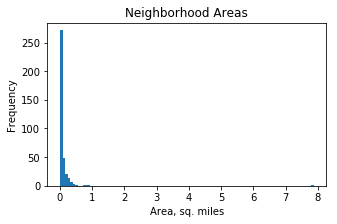

In [889]:
df.area.plot('hist', bins = 100, figsize = (5,3))
plt.title('Neighborhood Areas')
plt.xlabel('Area, sq. miles')
plt.ylabel('Frequency')

(0, 1)

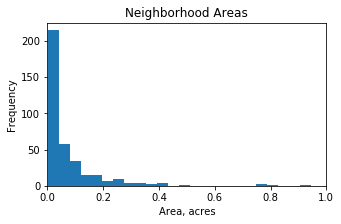

In [884]:
df.area.plot('hist', bins = 200, figsize = (5,3))
plt.title('Neighborhood Areas')
plt.xlabel('Area, acres')
plt.ylabel('Frequency')
plt.xlim([0,1])

It appears that area field has outliers. Let's explore it further via boxplot

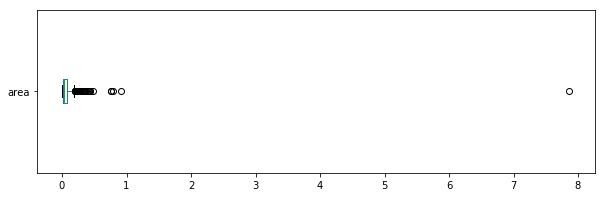

In [887]:
df.area.plot('box',figsize = (10,3), vert = False)

There is something going on here. Assuming that one house takes approximately 0.5 acres., let's discard neighborhoods with less than 4 houses (2/640 sq. miles):

In [892]:
df_areas = df[df.area >= 2.0/640]

Also, the neighborhood with the largest area is Murraywood in South Carolina:

In [900]:
df_areas[df_areas.area > 7]

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct not speak English well,pct single mother,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store,cluster,map_cluster
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Murraywood, Columbia, SC",7.865,6110,7.8,1.8,1.9,3055.0,37.8,40.4,81120.0,679.0,...,2.0,12.1,74.3,0.0,0.0,0.0,0.0,0.0,16,2.0


(0, 0.5)

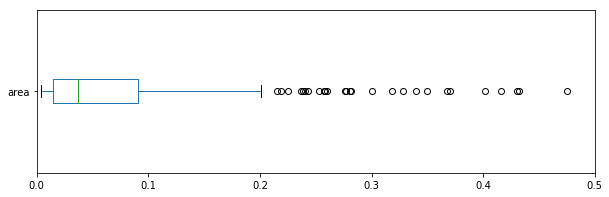

In [903]:
df_areas.area.plot('box', figsize = (10,3), vert = False)
plt.xlim([0,0.5])

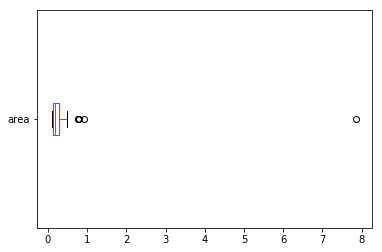

In [906]:
df_areas[df_areas.area > 0.1].area.plot('box', vert = False)

Murraywood neighborhood is the top outlier and majority of neighborhoods in Raleigh have way smaller area. One possible reason is that neighborhoods in the dataset are 'split', i.e. multiple rows represent the same neighborhood. Area will be excluded from further analysis

## Average household size

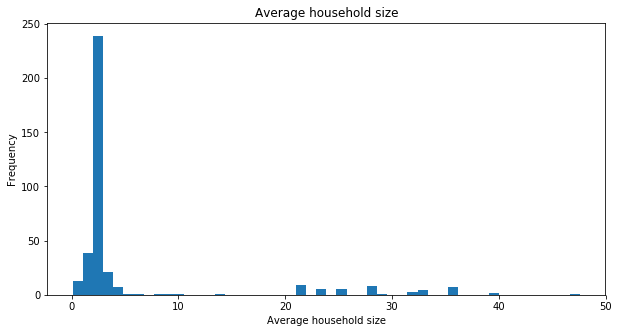

In [913]:
df['avg household size'].plot('hist', bins = 50, figsize = (10,5))
plt.xlabel('Average household size')
plt.title('Average household size')

Let's take a closer look at household sizes with more than 10 people:

In [940]:
df[df['avg household size'] > 10].head()

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct not speak English well,pct single mother,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store,cluster,map_cluster
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Alanda, Raleigh, NC",0.019,4,21.0,1.7,1.7,2.0,36.7,30.7,65332.0,853.0,...,0.0,8.5,96.9,0.0,0.0,0.0,0.0,0.0,10,18.0
"Ashebrook, Raleigh, NC",0.056,16,39.5,1.0,2.3,7.0,25.7,46.0,51273.0,619.0,...,0.0,6.7,90.6,0.0,0.0,0.0,0.0,0.0,9,17.0
"Ashebrook, Raleigh, NC",0.056,16,39.5,1.0,2.3,7.0,25.7,46.0,51273.0,619.0,...,0.0,6.7,90.6,0.0,0.0,0.0,0.0,0.0,9,17.0
"Aztec Park, Raleigh, NC",0.039,9,21.0,1.7,1.7,5.0,36.7,30.7,65332.0,853.0,...,0.0,7.7,96.9,0.0,0.0,0.0,0.0,0.0,10,18.0
"Biltmore Hills, Raleigh, NC",0.164,2111,23.8,1.9,3.2,942.0,43.2,37.2,51299.0,734.0,...,4.1,15.4,86.0,0.0,0.0,0.0,0.0,0.0,9,17.0


Neighborhoods with more than 10 people on average per household do not appear legit. Let's clean them

In [925]:
df_household = df[(df['avg household size'] < 10)]
df_household.shape

(324, 29)

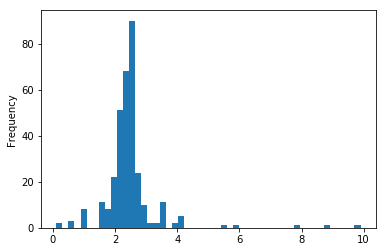

In [926]:
df_household['avg household size'].plot('hist', bins = 50)

## Average number of cars in appartments and houses

In [ ]:
df_household.loc[:,'avg number of cars'] = (df_household['avg number of cars apts'] + df_household['avg number of cars apts'])/2.0

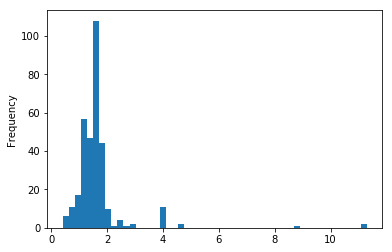

In [947]:
df_household['avg number of cars'].plot('hist', bins = 50)

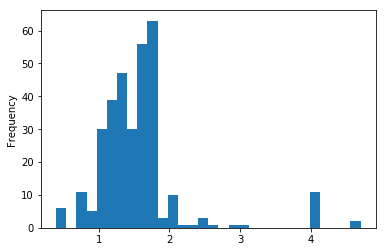

In [948]:
df_cars = df_household[df_household['avg number of cars'] < 5]
df_cars['avg number of cars'].plot('hist', bins = 30)

## Medium Age

In [ ]:
df_cars['med age'] = (df_cars['med age females'] + df_cars['med age males'])/2.0

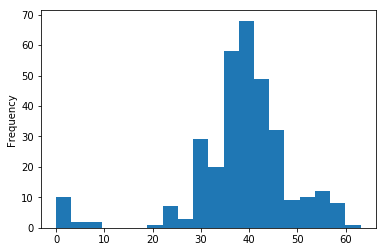

In [939]:
df_cars['med age'].plot('hist', bins = 20)

A few neighborhoods appear to have suspiciously young residents. Perhaps in some neighborhoods, the number of children is higher than the number of adults?

## Median Household income and rent

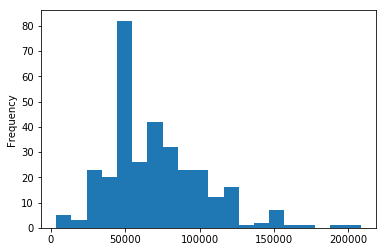

In [944]:
df_cars['med household income'].plot('hist', bins = 20)
plt.xlabel('Income')
plt.title('Median Household Income')

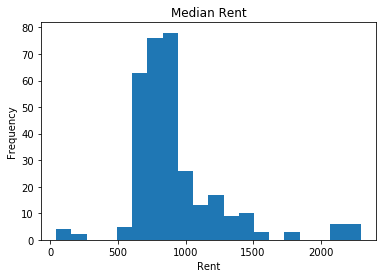

In [949]:
df_cars['med rent'].plot('hist', bins = 20)
plt.xlabel('Rent')
plt.title('Median Rent')

## Families with children, family household, married couples

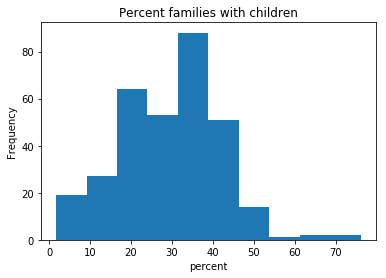

In [953]:
df_cars['pct families with children'].plot('hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent families with children')

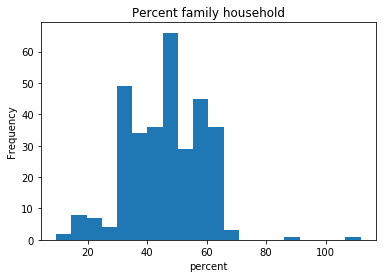

In [955]:
df_cars['pct family household'].plot('hist', bins = 20)
plt.xlabel('percent')
plt.title('Percent family household')

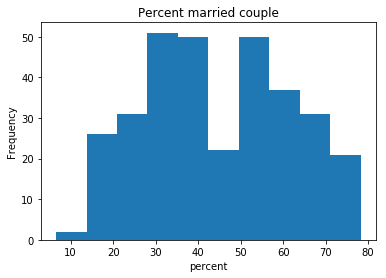

In [957]:
df_cars['pct married couple'].plot('hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent married couple')

Percents should not exceed 100 and there is only one neighborhood with a single resident, which can be discarded:

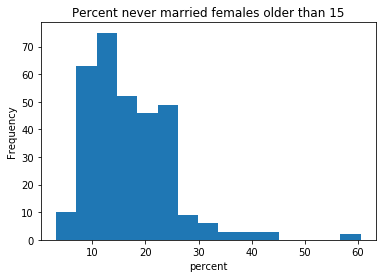

In [968]:
df_cars['pct never married females > 15'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent never married females older than 15')

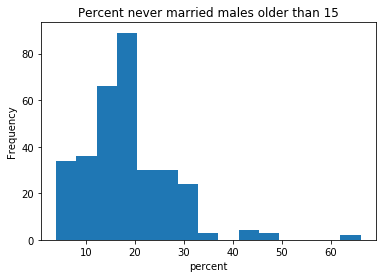

In [969]:
df_cars['pct never married males > 15'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent never married males older than 15')

## Percent residents born in other states or outside the U.S.

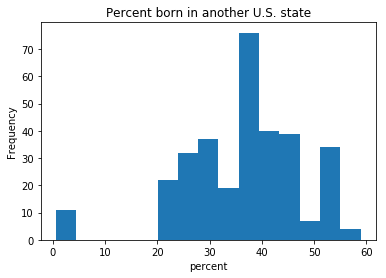

In [961]:
df_cars['pct born in another us state'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent born in another U.S. state')

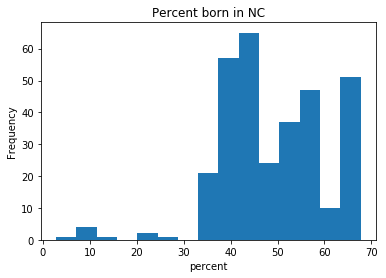

In [963]:
df_cars['pct born in state'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent born in NC')

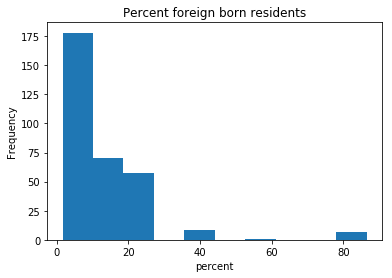

In [965]:
df_cars['pct foreign born residents'].plot('hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent foreign born residents')

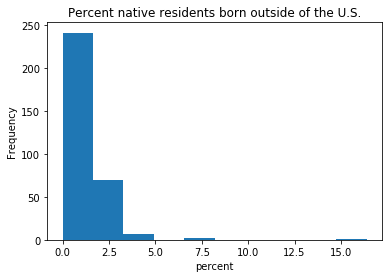

In [966]:
df_cars['pct native residents born outside us'].plot('hist', bins = 10)
plt.xlabel('percent')
plt.title('Percent native residents born outside of the U.S.')

## Other fields

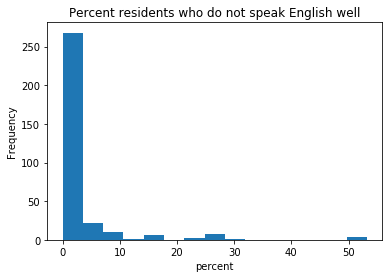

In [970]:
df_cars['pct not speak English well'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent residents who do not speak English well')

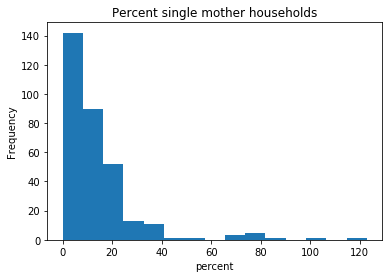

In [971]:
df_cars['pct single mother'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent single mother households')

In [972]:
df_cars[df_cars['pct single mother'] >= 100]

,area,population,avg household size,avg number of cars apts,avg number of cars houses,males,med age females,med age males,med household income,med rent,...,pct single mother,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store,cluster,map_cluster,avg number of cars
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Beasley Heights, Raleigh, NC",0.004,1,2.2,4.1,1.7,1.0,52.4,41.7,49125.0,678.0,...,122.9,85.3,0.0,0.0,0.0,0.0,0.0,9,17.0,4.1
"Crown Crossing, Raleigh, NC",0.007,2,2.2,4.1,1.7,1.0,52.4,41.7,49125.0,678.0,...,106.1,85.3,0.5,0.0,0.0,0.0,0.0,9,17.0,4.1


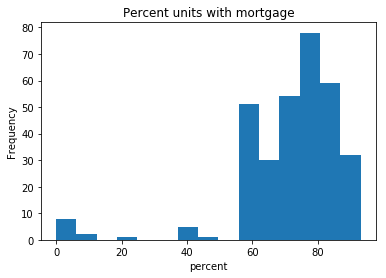

In [973]:
df_cars['pct units mortgage'].plot('hist', bins = 15)
plt.xlabel('percent')
plt.title('Percent units with mortgage')

## Filter out invalid data

In [985]:
df_clean = df_cars[(df_cars['pct single mother'] < 100) & (df_cars['pct family household'] < 100)]
df_clean.shape

(318, 30)

In [987]:
# Save for further use
df_clean.to_csv('raleigh_murraywood_neighs_clean3.csv')

# Correlation between fields

In [8]:
df_clean = pd.read_csv('raleigh_murraywood_neighs_clean3.csv', index_col = 0)
df_clean.drop(['cluster','map_cluster'],axis = 1).columns

Index(['area', 'population', 'avg household size', 'avg number of cars apts',
       'avg number of cars houses', 'males', 'med age females',
       'med age males', 'med household income', 'med rent',
       'pct born in another us state', 'pct born in state',
       'pct families with children', 'pct family household',
       'pct foreign born residents', 'pct married couple',
       'pct native residents born outside us',
       'pct never married females > 15', 'pct never married males > 15',
       'pct not speak English well', 'pct single mother', 'pct units mortgage',
       'Park', 'Pool', 'Trail', 'Pizza Place', 'Convenience Store',
       'avg number of cars'],
      dtype='object')

## Social attributes

The dataset contains has too many fields to visualize them all at once. So, first visualize correlation between social attributes.

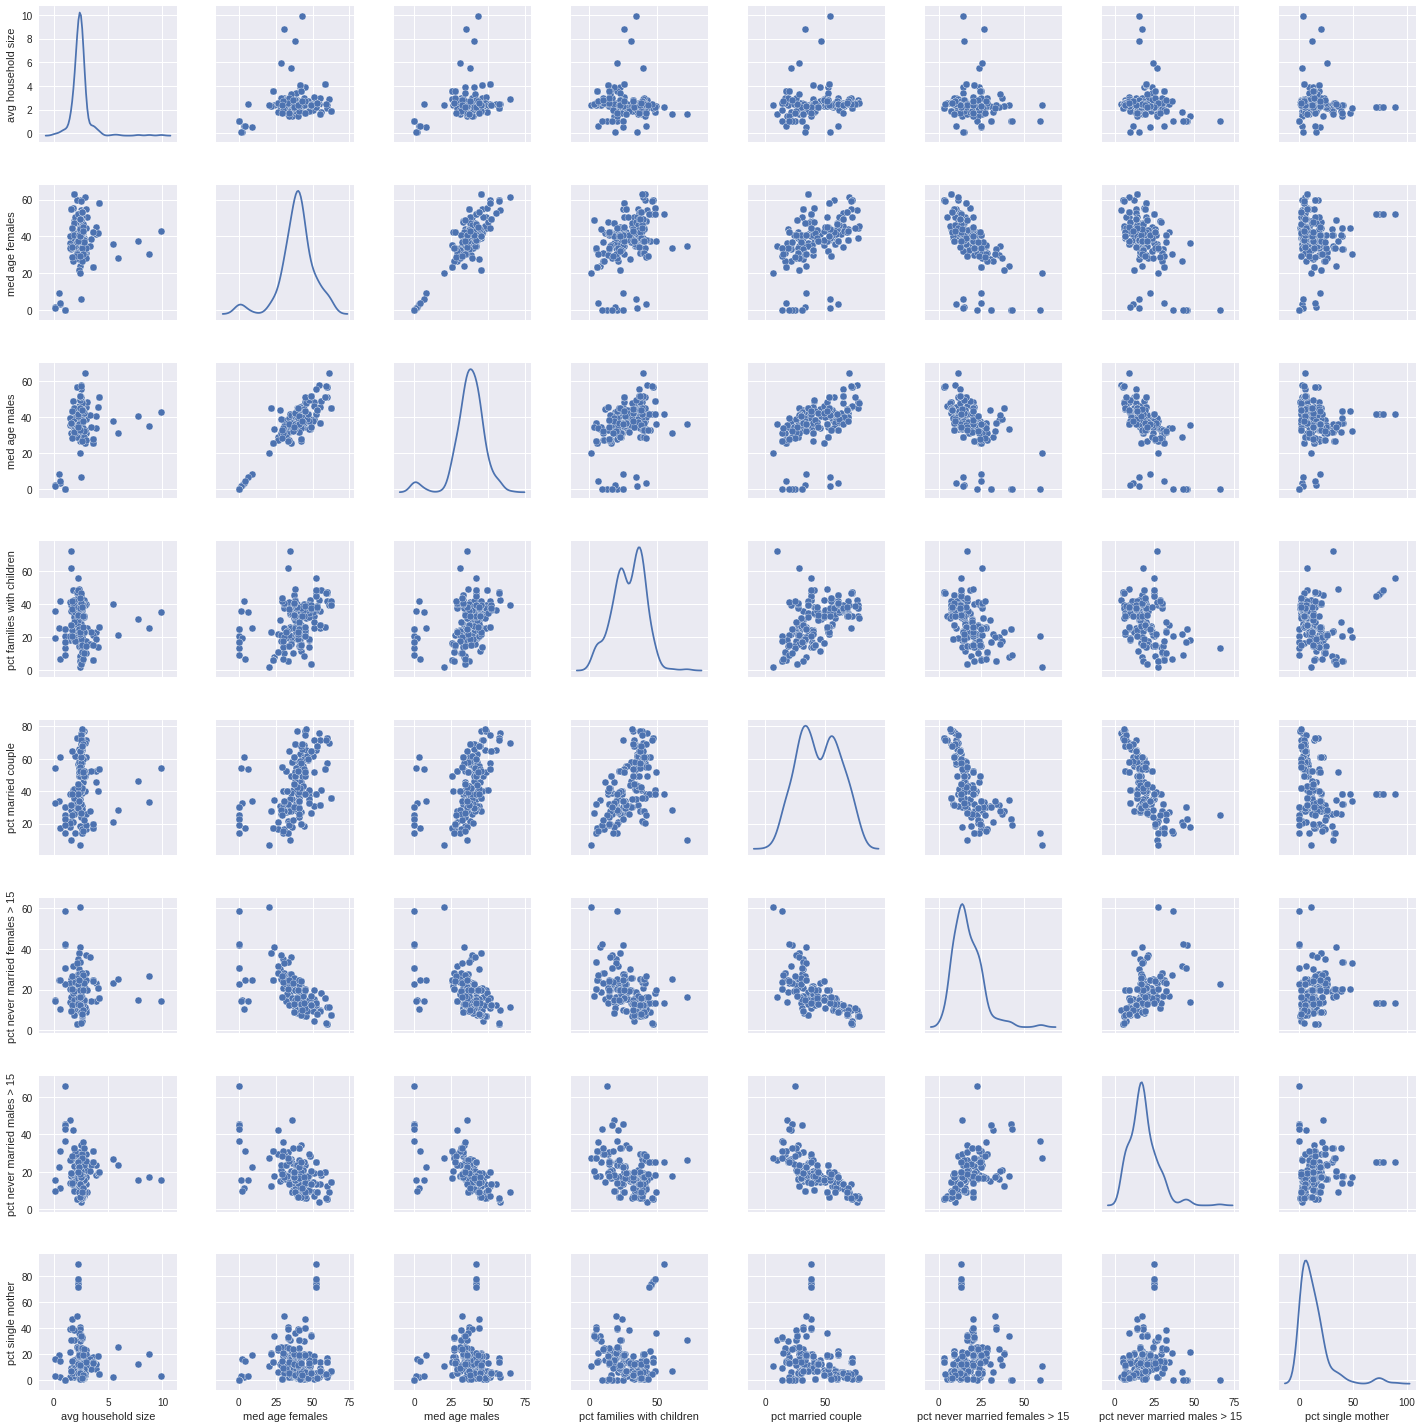

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(df_clean.drop(['cluster','map_cluster'],axis = 1), diag_kind="kde",
             vars = ['avg household size'
                                                                ,'med age females','med age males'
                                                               ,'pct families with children'
                                                               ,'pct married couple'
                                                               ,'pct never married females > 15'
                                                               ,'pct never married males > 15'
                                                               ,'pct single mother'])
plt.show()

Summary -- The data demonstrates rather weak positive and negative correlations.

## Economic attributes and proximity to venues

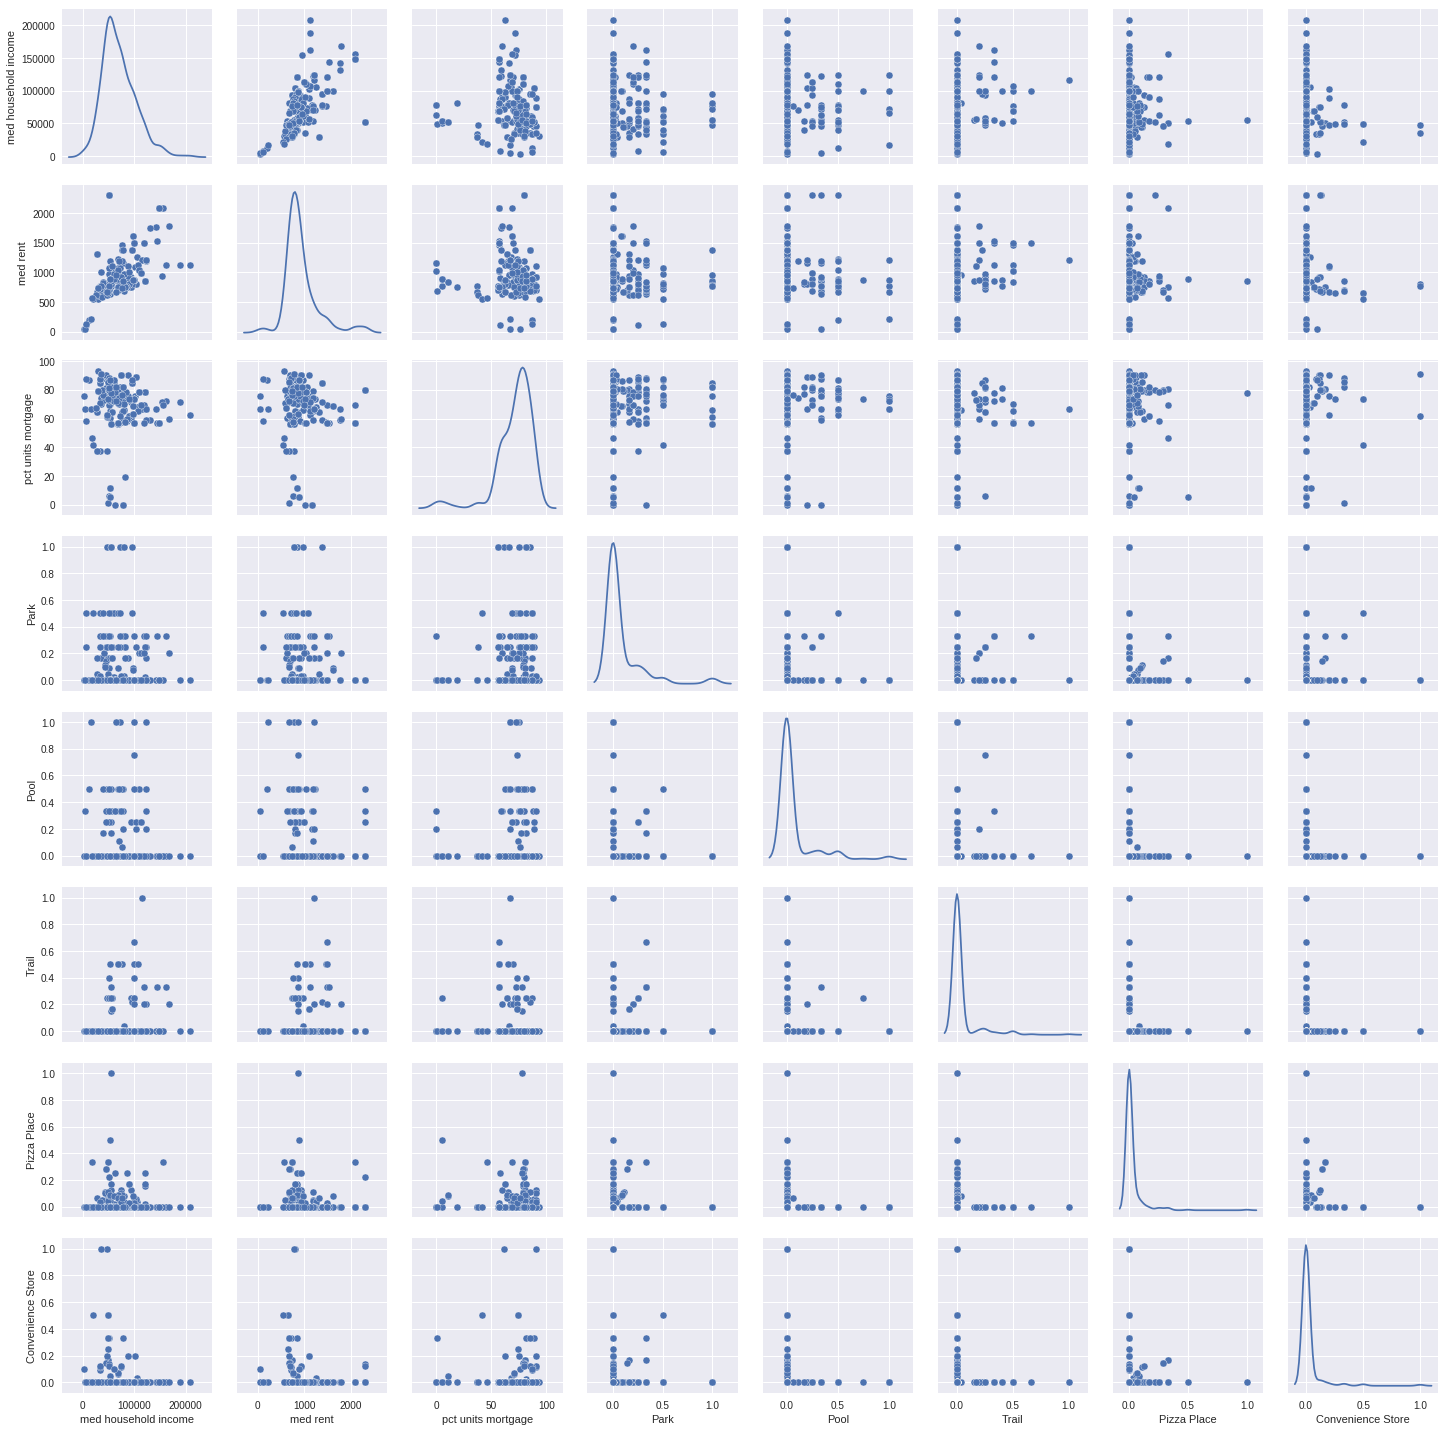

In [134]:
sns.pairplot(df_clean.drop(['cluster','map_cluster'],axis = 1), diag_kind="kde",
             vars = ['med household income', 'med rent'
                                                                ,'pct units mortgage'
                                                                ,'Park', 'Pool', 'Trail', 'Pizza Place'
                                                                ,'Convenience Store'
                                                               ])
plt.show()

The venue data looks more sparse, however it still makes sense to include it in further analysis.

### Summary

For further analysis and clustering, we chose the following set of fields:

'avg household size','med age females','med age males','pct families with children','pct married couple'
                                                               ,'pct never married females > 15'
                                                               ,'pct never married males > 15'
                                                               ,'pct single mother'
                                                               ,'med household income', 'med rent'
                                                                ,'pct units mortgage'
                                                                ,'Park', 'Pool', 'Trail', 'Pizza Place'
                                                                ,'Convenience Store'

In [21]:
df_clean.drop(['cluster','map_cluster'], axis = 1)[['avg household size'
                                                    ,'med age females','med age males'
                                                    ,'pct families with children','pct married couple'
                                                    ,'pct never married females > 15'
                                                    ,'pct never married males > 15'
                                                    ,'pct single mother' ,'med household income'
                                                    ,'med rent' ,'pct units mortgage' 
                                                    ,'Park', 'Pool', 'Trail', 'Pizza Place' ,'Convenience Store'
                                                   ]].to_csv('raleigh_murraywood_neighs_clean4.csv')

# Clustering

The core of the analytic method is -- clustering of the neighborhoods by socioeconomic and venues fields. 

In [22]:
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('raleigh_murraywood_neighs_clean4.csv', index_col = 0)
arr = StandardScaler().fit_transform(df)

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

## Optimum number of clusters

To find the optimum number of clusters, apply 'elbow' method. The idea behind the method is to find average squared distances to cluster centers for various number of clusters. The optimum number of clusters is around the place where the distance stops dropping quickly, i.e. the 'elbow'.

In [31]:
max_k = 50
squared_distance = np.zeros(max_k)
for k in range(2,max_k):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(arr)
    squared_distance[k] = kmeans.inertia_
    print(k,sep=' ', end=' ', flush=True)

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

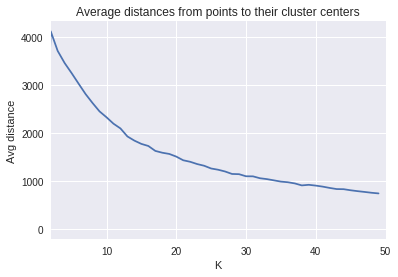

In [32]:
plt.figure()
plt.plot(squared_distance)
plt.xlabel('K')
plt.ylabel('Avg distance')
plt.title('Average distances from points to their cluster centers')
plt.xlim([2,max_k])
plt.show()

In [28]:
kclusters = 12 # the optimum number of clusters
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(df)
df['cluster'] = kmeans.labels_

In [33]:
# Murraywood cluster number
df.loc['Murraywood, Columbia, SC','cluster']

11.0

### Cluster centers
Median household income appears one of the most significant feature, so order clusters by it:

In [35]:
df.groupby('cluster').mean().sort_values('med household income', ascending = False)

,avg household size,med age females,med age males,pct families with children,pct married couple,pct never married females > 15,pct never married males > 15,pct single mother,med household income,med rent,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store
cluster,,,,,,,,,,,,,,,,
6,2.500000,49.450000,54.750000,40.600000,75.400000,10.400000,5.450000,4.300000,198252.500000,1125.000000,67.050000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2.766667,50.400000,52.133333,34.900000,72.900000,8.200000,7.833333,2.900000,162000.333333,1663.000000,67.033333,0.177778,0.000000,0.177778,0.111111,0.000000
10,2.550000,50.662500,45.650000,37.075000,65.250000,9.537500,10.700000,2.812500,147450.000000,1829.250000,59.875000,0.041667,0.000000,0.041667,0.000000,0.000000
8,2.476471,43.870588,45.488235,36.964706,66.147059,10.594118,10.694118,2.170588,122273.823529,1125.352941,70.376471,0.106078,0.119608,0.043137,0.034736,0.000000
7,3.207692,43.453846,42.407692,32.815385,66.730769,9.392308,9.200000,5.484615,110807.384615,1057.846154,73.684615,0.030769,0.076923,0.115385,0.002481,0.002481
1,2.368182,50.077273,49.736364,40.331818,64.713636,9.395455,11.486364,8.481818,99845.409091,1134.636364,68.950000,0.034144,0.122727,0.103030,0.010091,0.009091
9,2.521739,42.847826,37.539130,36.552174,54.839130,13.169565,16.995652,5.878261,92447.782609,959.173913,70.295652,0.072464,0.010870,0.020531,0.032115,0.008696
11,2.259375,41.784375,39.140625,31.781250,44.009375,15.981250,16.131250,9.303125,78821.031250,906.812500,64.787500,0.167675,0.050000,0.016875,0.009734,0.010417
2,2.582927,39.882927,36.092683,30.163415,51.343902,13.785366,20.060976,13.758537,71296.097561,900.926829,74.239024,0.072110,0.088076,0.036585,0.015572,0.008909


### Murraywood cluster
Summary of neighborhoods in Raleigh from the same cluster (11) as Murraywood:

In [41]:
df[df.cluster == 11].mean()

avg household size                    2.259375
med age females                      41.784375
med age males                        39.140625
pct families with children           31.781250
pct married couple                   44.009375
pct never married females > 15       15.981250
pct never married males > 15         16.131250
pct single mother                     9.303125
med household income              78821.031250
med rent                            906.812500
pct units mortgage                   64.787500
Park                                  0.167675
Pool                                  0.050000
Trail                                 0.016875
Pizza Place                           0.009734
Convenience Store                     0.010417
cluster                              11.000000
dtype: float64

### List of Raleigh neighborhoods in Murraywood cluster

In [43]:
df[df.cluster == 11].index

Index(['Alexander Place Townhomes, Raleigh, NC',
       'Anderson Forest, Raleigh, NC',
       'Arbor at Harrington Grove, Raleigh, NC', 'Blenheim Place, Raleigh, NC',
       'Cambridge, Raleigh, NC', 'Cambridge, Raleigh, NC',
       'Cambridge, Raleigh, NC', 'Cameron Village, Raleigh, NC',
       'Cedar Hills Estates, Raleigh, NC', 'Chadleigh Pointe, Raleigh, NC',
       'Claridge, Raleigh, NC', 'College Crest, Raleigh, NC',
       'Colony Woods, Raleigh, NC', 'Eden Forest, Raleigh, NC',
       'Evans Mill, Raleigh, NC', 'Glenanneve Place, Raleigh, NC',
       'Grove Park, Raleigh, NC', 'Jordan, Raleigh, NC',
       'Lyon Park, Raleigh, NC', 'Murraywood, Columbia, SC',
       'North Park, Raleigh, NC', 'Northglen, Raleigh, NC',
       'Northwood Acres, Raleigh, NC',
       'Parliament Pointe at Greystone, Raleigh, NC', 'Ponderosa, Raleigh, NC',
       'Roanoke Park, Raleigh, NC', 'Scarsdale, Raleigh, NC',
       'Sloans Garden Lane, Raleigh, NC', 'Springstone, Raleigh, NC',
       'St

## Map of clusters in Raleigh

Since there are many clusters (12), it would be nice to reorder their numbers according to one of the fields. For instance, clusters with low numbers represent low median income and vice a versa:

In [49]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import pickle

In [44]:
# Sort the clusters by median household income
field, asc = 'med household income', True
clusters = list(df.groupby('cluster').mean().sort_values(field, ascending = asc).index.values)
new_clusters = np.arange(0,max(clusters))
rename_dict = dict(zip(clusters, new_clusters))
df['map_cluster'] = df['cluster'].map(rename_dict)

In [47]:
import pickle
# Load neighborhood coordinates file
with open('coords.pickle','rb') as f:
    coords =pickle.load(f)
    
df_coords = pd.DataFrame(coords, columns = ['Neighborhood','lat','lon'])
df_coords = df_coords.set_index('Neighborhood')
df_coords.head()

,lat,lon
Neighborhood,,
"Fieldstone Crossing, Raleigh, NC",35.760808,-78.556795
"Bryarton, Raleigh, NC",35.750249,-78.731474
"Brook Forest, Raleigh, NC",35.780398,-78.639099
"Ashley Ridge, Raleigh, NC",35.869108,-78.668662
"Fox Hollow, Raleigh, NC",35.740117,-78.608463


In [48]:
# Join with other data
df_map = df_coords.join(df[['map_cluster',field]]).dropna()
df_map.head()

,lat,lon,map_cluster,med household income
Neighborhood,,,,
"Alexander Place Townhomes, Raleigh, NC",35.912906,-78.771160,7.0,77721.0
"Alpha, Raleigh, NC",35.742792,-78.691270,3.0,45978.0
"Amberfield, Raleigh, NC",35.817335,-78.555592,4.0,53929.0
"Ammondale, Raleigh, NC",35.869316,-78.636444,2.0,34719.0
"Anderson Forest, Raleigh, NC",35.823332,-78.630841,7.0,76395.0


### All Raleigh neighborhoods

The map shows all neighborhoods colored according to median household income. Neighborhoods similar to Murraywood are in cluster 7

In [105]:
from pylab import *
cmap = plt.cm.plasma    # PiYG

palette = [matplotlib.colors.rgb2hex(cmap(int(i*cmap.N/kclusters+1))[:3]) for i in range(kclusters)]
#palette

# create map
latitude, longitude = 35.76081, -78.5568
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

markers_colors = []
for lat, lon, poi, cluster, f in zip(df_map['lat']\
                                  , df_map['lon']\
                                  , df_map.index\
                                  , df_map['map_cluster']
                                  , df_map[field]):
    label_text = "%s, cluster: %d, %s:%d"%(str(poi),cluster, field, f)
    label = folium.Popup(label_text, parse_html=True)
    cluster = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=palette[cluster],
        fill=True,
        fill_color=palette[cluster],
        fill_opacity=0.7,
        cmap = plt.cm.plasma,
    ).add_to(map_clusters)
    
map_clusters

### Murraywood cluster

The map below shows _only_ neighborhoods that are similar to Murraywood, i.e. within cluster #7

In [108]:
df_map[df_map.index == 'Murraywood, Columbia, SC']

,lat,lon,map_cluster,med household income
Neighborhood,,,,
"Murraywood, Columbia, SC",34.076736,-81.178912,7.0,81120.0


In [114]:
from pylab import *
cmap = plt.cm.plasma    # PiYG

palette = [matplotlib.colors.rgb2hex(cmap(int(i*cmap.N/kclusters+1))[:3]) for i in range(kclusters)]
#palette

# create map
latitude, longitude = 35.76081, -78.5568
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

markers_colors = []
for lat, lon, poi, cluster, f in zip(df_map['lat']\
                                  , df_map['lon']\
                                  , df_map.index\
                                  , df_map['map_cluster']
                                  , df_map[field]):
    label_text = "%s, cluster: %d, %s:%d"%(str(poi),cluster, field, f)
    label = folium.Popup(label_text, parse_html=True)
    cluster = int(cluster)
    if cluster == 7:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=palette[cluster],
            fill= True,
            fill_color=palette[cluster],
            fill_opacity= 0.7,
            cmap = plt.cm.plasma,
        ).add_to(map_clusters)
    
map_clusters

## Clusters in Socioeconomic data

This section revisits the correlation plot from above, but it paints Murraywood cluster in different color.

In [121]:
# Join cluster information with other neighborhood data
df_hist_analysis = df_coords.join(df).dropna()
df_hist_analysis.head()

,lat,lon,avg household size,med age females,med age males,pct families with children,pct married couple,pct never married females > 15,pct never married males > 15,pct single mother,med household income,med rent,pct units mortgage,Park,Pool,Trail,Pizza Place,Convenience Store,cluster,map_cluster
Neighborhood,,,,,,,,,,,,,,,,,,,,
"Alexander Place Townhomes, Raleigh, NC",35.912906,-78.771160,2.2,37.9,38.0,39.2,56.5,10.0,12.6,7.9,77721.0,1159.0,0.0,0.0,0.200000,0.0,0.0,0.0,11.0,7.0
"Alpha, Raleigh, NC",35.742792,-78.691270,2.4,24.0,33.5,7.9,34.3,41.0,17.5,33.8,45978.0,677.0,87.7,0.0,0.333333,0.0,0.0,0.0,13.0,3.0
"Amberfield, Raleigh, NC",35.817335,-78.555592,2.3,40.8,36.0,25.0,34.1,24.9,22.6,19.1,53929.0,895.0,86.6,0.0,0.000000,0.0,0.0,0.0,4.0,4.0
"Ammondale, Raleigh, NC",35.869316,-78.636444,2.5,32.6,30.9,23.9,40.0,17.8,17.6,11.2,34719.0,693.0,84.7,0.0,0.000000,0.0,0.0,0.0,0.0,2.0
"Anderson Forest, Raleigh, NC",35.823332,-78.630841,2.3,41.3,42.4,35.0,63.0,12.8,14.3,5.9,76395.0,1454.0,57.3,0.0,0.000000,0.5,0.0,0.0,11.0,7.0


In [127]:
df_hist_analysis['similar to Murraywood'] = df_hist_analysis['map_cluster'] == 7

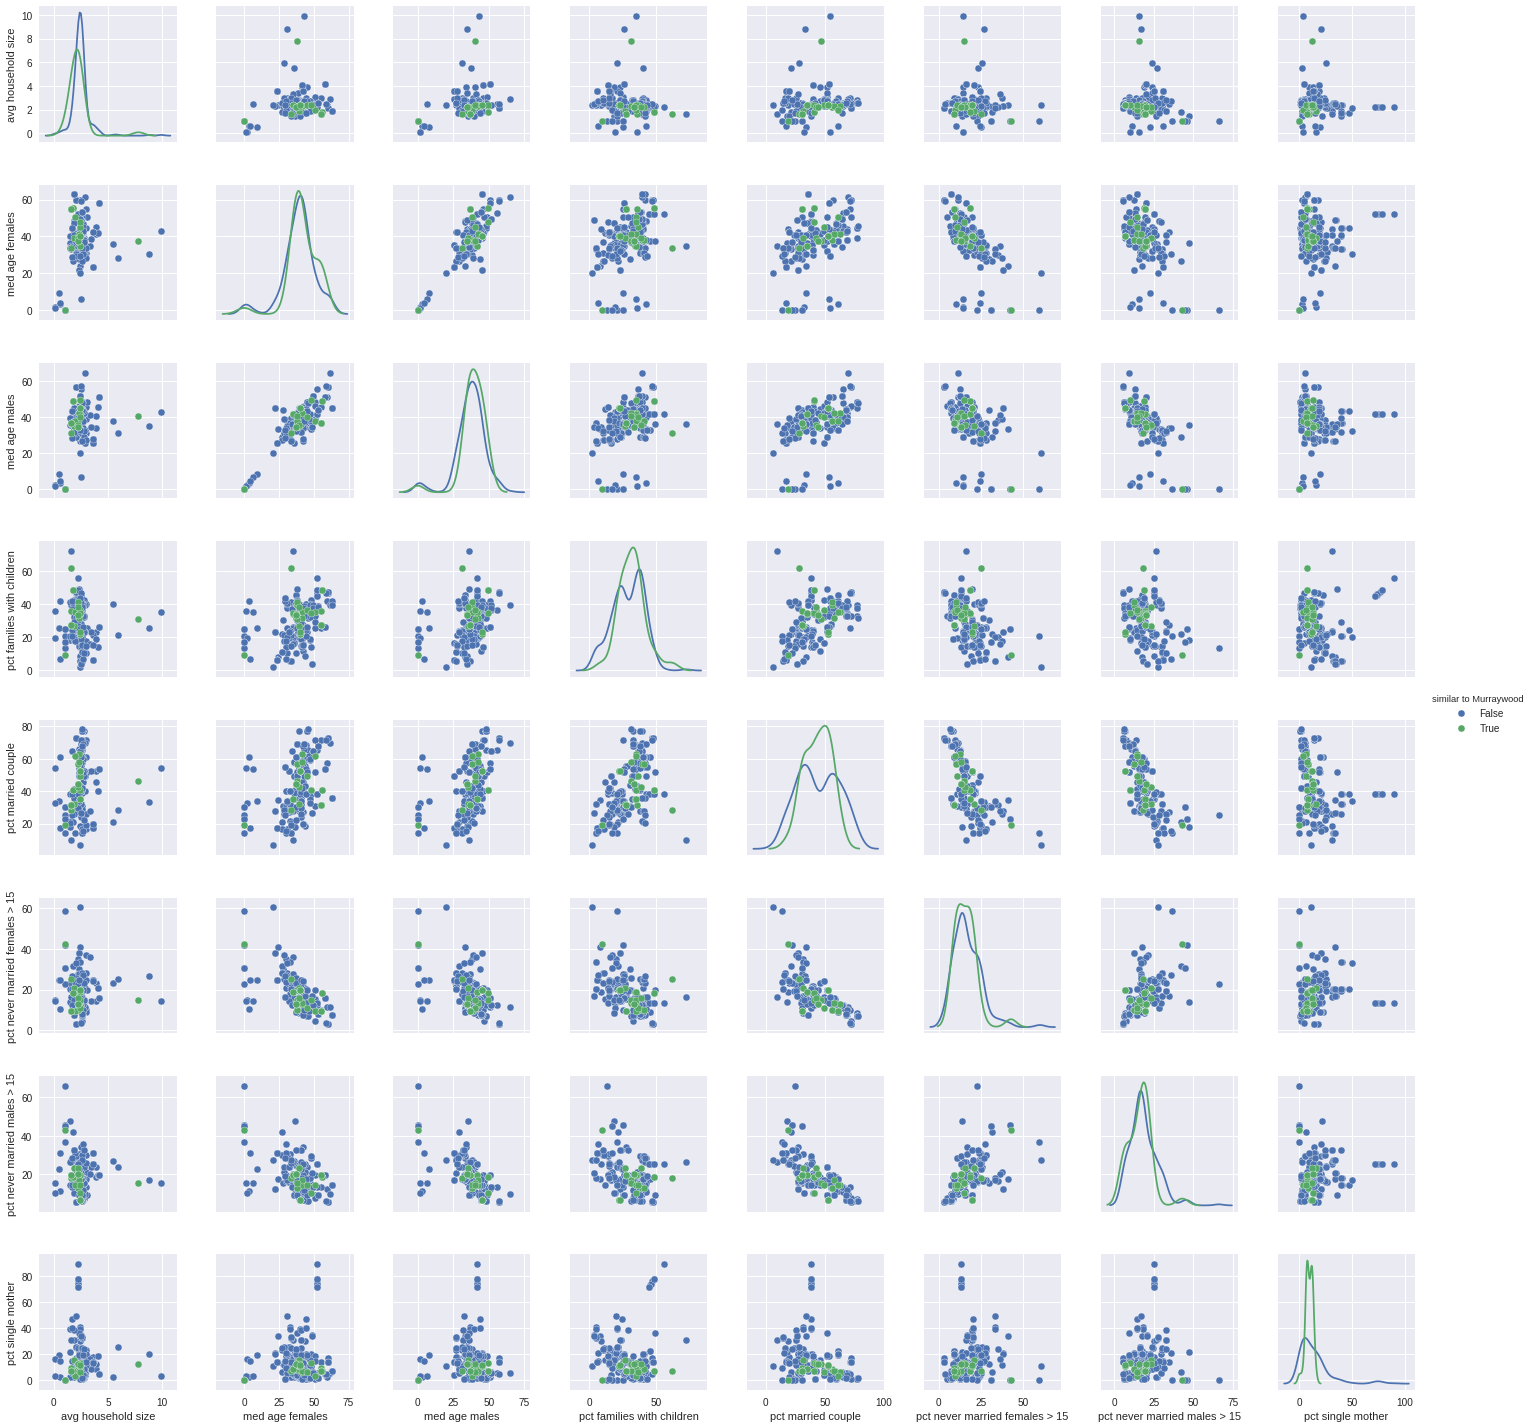

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(df_hist_analysis, diag_kind="kde",
             vars = ['avg household size'
                                                                ,'med age females','med age males'
                                                               ,'pct families with children'
                                                               ,'pct married couple'
                                                               ,'pct never married females > 15'
                                                               ,'pct never married males > 15'
                                                               ,'pct single mother'],
            hue='similar to Murraywood')
plt.show()